In [41]:
# Importing required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# Load the datasets
try:
    match = pd.read_csv('matches.csv')
    delivery = pd.read_csv('deliveries.csv')
except FileNotFoundError as e:
    print(f"Error: Could not find the required CSV files. {e}")
    exit(1)

print("Datasets loaded successfully.")
print(f"Matches dataset shape: {match.shape}")
print(f"Deliveries dataset shape: {delivery.shape}")

Datasets loaded successfully.
Matches dataset shape: (756, 18)
Deliveries dataset shape: (179078, 21)


In [43]:
# Data Preprocessing
# Calculate total runs for each match and inning
total_score_df = delivery.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()
total_score_df = total_score_df[total_score_df['inning'] == 1]

# Merge match data with total runs
match_df = match.merge(total_score_df[['match_id', 'total_runs']], left_on='id', right_on='match_id')

# List of current IPL teams
teams = [
    'Sunrisers Hyderabad', 'Mumbai Indians', 'Royal Challengers Bangalore',
    'Kolkata Knight Riders', 'Kings XI Punjab', 'Chennai Super Kings',
    'Rajasthan Royals', 'Delhi Capitals'
]

In [44]:
# Update team names for consistency
team_name_mapping = {
    'Delhi Daredevils': 'Delhi Capitals',
    'Deccan Chargers': 'Sunrisers Hyderabad'
}
match_df['team1'] = match_df['team1'].replace(team_name_mapping)
match_df['team2'] = match_df['team2'].replace(team_name_mapping)

# Filter matches for current teams and without DL method applied
match_df = match_df[
    match_df['team1'].isin(teams) & 
    match_df['team2'].isin(teams) & 
    (match_df['dl_applied'] == 0)
]

In [45]:
# Select relevant columns
match_df = match_df[['match_id', 'city', 'winner', 'total_runs']]

# Merge match data with delivery data
delivery_df = match_df.merge(delivery, on='match_id')
delivery_df = delivery_df[delivery_df['inning'] == 2]

print("Data preprocessing completed.")
print(f"Processed dataset shape: {delivery_df.shape}")

Data preprocessing completed.
Processed dataset shape: (72413, 24)


In [46]:
# Feature Engineering
try:
    # Calculate current score and other metrics
    delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()
    delivery_df['balls_bowled'] = delivery_df['over'] * 6 + delivery_df['ball']
    delivery_df['balls_left'] = 120 - delivery_df['balls_bowled']
    
    # Handle wickets calculation
    delivery_df['player_dismissed'] = delivery_df['player_dismissed'].notna().astype(int)
    delivery_df['wickets'] = 10 - delivery_df.groupby('match_id')['player_dismissed'].cumsum()
    
    # Calculate runs left and run rates
    delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']
    
    # Calculate run rates with proper handling of edge cases
    delivery_df['crr'] = np.where(
        delivery_df['balls_bowled'] > 0,
        (delivery_df['current_score'] * 6) / delivery_df['balls_bowled'],
        0
    )
    
    # Calculate required run rate and handle edge cases
    delivery_df['rrr'] = np.where(
        delivery_df['balls_left'] > 0,
        (delivery_df['runs_left'] * 6) / delivery_df['balls_left'],
        20  # High RRR for situations with very few balls left
    )
    
    # Add new features to improve model performance
    delivery_df['wickets_left_percentage'] = delivery_df['wickets'] / 10
    delivery_df['balls_left_percentage'] = delivery_df['balls_left'] / 120
    delivery_df['runs_left_percentage'] = np.where(
        delivery_df['total_runs_x'] > 0,
        delivery_df['runs_left'] / delivery_df['total_runs_x'],
        0
    )
    
except Exception as e:
    print(f"Error during calculations: {e}")
    exit(1)

print("Feature engineering completed.")

Feature engineering completed.


In [47]:
# Define the result (1 if batting team wins, 0 otherwise)
delivery_df['result'] = (delivery_df['batting_team'] == delivery_df['winner']).astype(int)

# Select features for the model
final_df = delivery_df[[
    'batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left',
    'wickets', 'total_runs_x', 'crr', 'rrr', 'wickets_left_percentage',
    'balls_left_percentage', 'runs_left_percentage', 'result'
]]

# Clean the dataset
final_df = final_df.dropna()
final_df = final_df[final_df['balls_left'] != 0]

# Remove extreme outliers
final_df = final_df[final_df['rrr'] <= 36]  # Max 6 runs per ball
final_df = final_df[final_df['crr'] <= 36]

print("Final dataset prepared.")
print(f"Final dataset shape: {final_df.shape}")

Final dataset prepared.
Final dataset shape: (69311, 13)


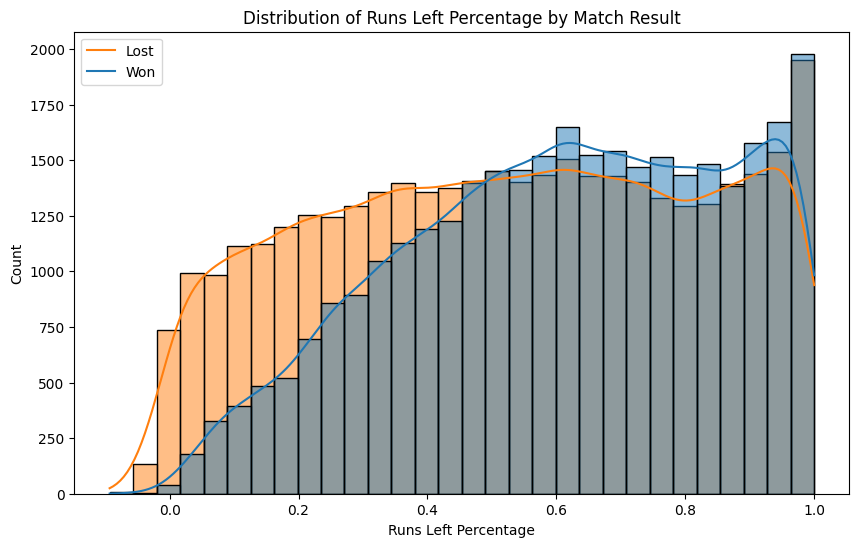

In [48]:
# Visualization 1: Distribution of runs left percentage
plt.figure(figsize=(10, 6))
sns.histplot(data=final_df, x='runs_left_percentage', hue='result', kde=True, bins=30)
plt.title('Distribution of Runs Left Percentage by Match Result')
plt.xlabel('Runs Left Percentage')
plt.ylabel('Count')
plt.legend(['Lost', 'Won'])
plt.show()

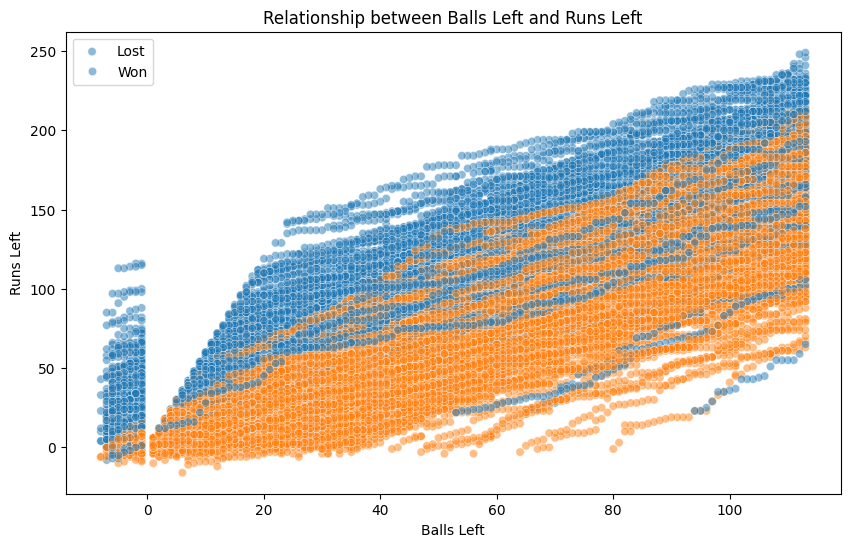

In [49]:
# Visualization 2: Relationship between balls left and runs left
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df, x='balls_left', y='runs_left', hue='result', alpha=0.5)
plt.title('Relationship between Balls Left and Runs Left')
plt.xlabel('Balls Left')
plt.ylabel('Runs Left')
plt.legend(['Lost', 'Won'])
plt.show()

Model Accuracy: 86.3233%
Model saved successfully as 'pipe.pkl'

Top 10 Most Important Features:
                        feature  importance
5                           rrr    0.253526
3                  total_runs_x    0.171350
6       wickets_left_percentage    0.091500
0                     runs_left    0.087403
2                       wickets    0.070064
8          runs_left_percentage    0.058934
4                           crr    0.044663
7         balls_left_percentage    0.028349
1                    balls_left    0.027019
9  batting_team_Deccan Chargers    0.012043


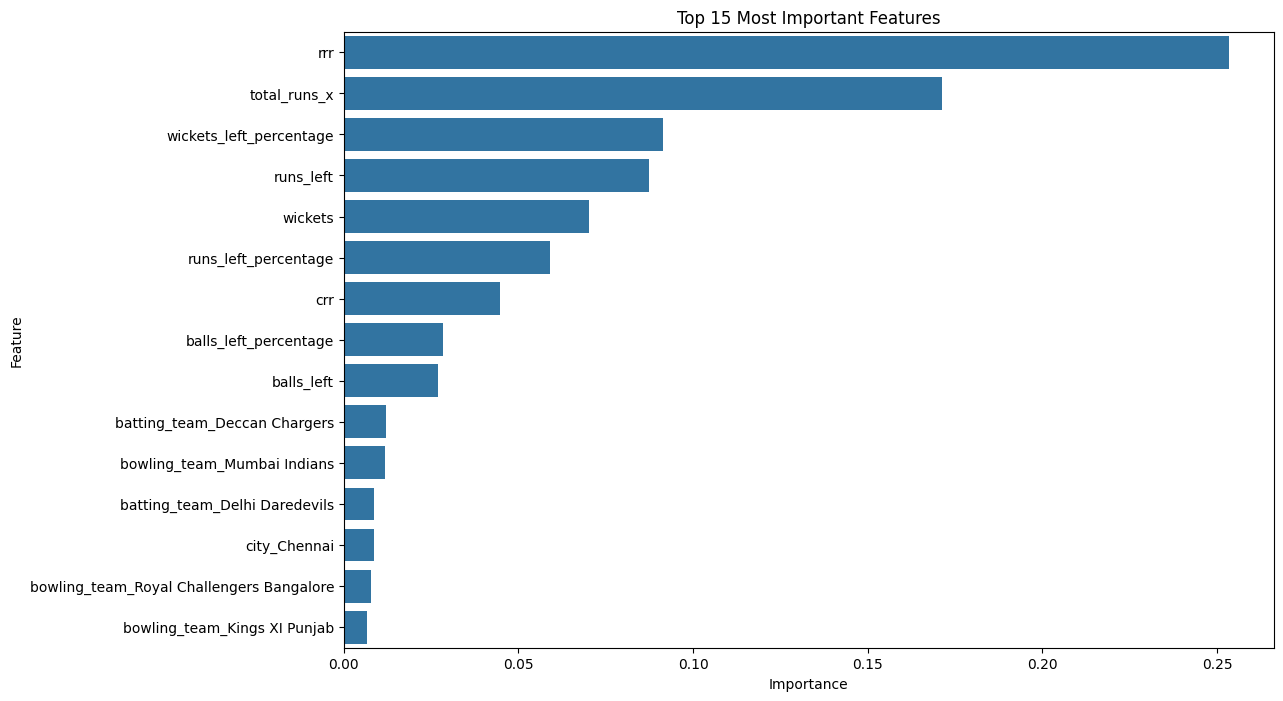


Data processing and model training completed successfully.


In [50]:
# Model Training
# Split the data into features (X) and target (y)
X = final_df.drop('result', axis=1)
y = final_df['result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

try:
    # Create preprocessing steps
    categorical_features = ['batting_team', 'bowling_team', 'city']
    numerical_features = ['runs_left', 'balls_left', 'wickets', 'total_runs_x', 
                         'crr', 'rrr', 'wickets_left_percentage', 
                         'balls_left_percentage', 'runs_left_percentage']

    # Create preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_features)
        ])

    # Create and train the pipeline with RandomForestClassifier
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, 
                                            max_depth=10,
                                            min_samples_split=5,
                                            min_samples_leaf=2,
                                            random_state=42))
    ])

    # Fit the pipeline
    pipe.fit(X_train, y_train)

    # Make predictions and calculate accuracy
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)*100
    print(f"Model Accuracy: {accuracy:.4f}%")

    # Save the trained model
    with open('pipe.pkl', 'wb') as f:
        pickle.dump(pipe, f)
    print("Model saved successfully as 'pipe.pkl'")

    # Print feature importance (for numerical features)
    feature_importance = pipe.named_steps['classifier'].feature_importances_
    feature_names = (numerical_features + 
                    pipe.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features).tolist())
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))

    # Visualization 3: Feature Importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=importance_df.head(15))
    plt.title('Top 15 Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

except Exception as e:
    print(f"Error during model training: {e}")
    exit(1)

print("\nData processing and model training completed successfully.")